# MT with transformers
I am not using weight tying in this version because source and target vocabulary sizes are different.

No label smoothing in this version too.

In [1]:
import torch
import chime
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import json
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from os.path import join
from datetime import datetime
import math

In [2]:
%load_ext chime

In [3]:
device = torch.device('cuda')

In [4]:
path = ''

In [5]:
with open(join(path, 'vocab_params.json')) as f:
    vocab_params = json.load(f)
src_vocab_size = vocab_params['src_vocab_size']
tgt_vocab_size = vocab_params['tgt_vocab_size']
tgt_bos = vocab_params['tgt_bos'] # Index of the <bos> token in the target set
tgt_eos = vocab_params['tgt_eos'] # Index of the <eos> token in the target set
pad = vocab_params['pad'] # Index of the padding token
max_sequence_length = vocab_params['max_sequence_length']

In [6]:
data = np.load(join(path, 'data.npz'))
data.files

['src_train', 'src_val', 'src_test', 'tgt_train', 'tgt_val', 'tgt_test']

In [7]:
src_train = data['src_train']
src_val = data['src_val']
src_test = data['src_test']
tgt_train = data['tgt_train']
tgt_val = data['tgt_val']
tgt_test = data['tgt_test']

In [8]:
with open(join(path, 'lengths.json')) as f:
    lengths = json.load(f)
src_lengths_train = lengths['src_lengths_train']
src_lengths_val = lengths['src_lengths_val']
src_lengths_test = lengths['src_lengths_test']
tgt_lengths_train =  lengths['tgt_lengths_train']
tgt_lengths_val = lengths['tgt_lengths_val']

In [9]:
last_model_state_path = join(path, 'last_model_state.pt')
best_model_state_path = join(path, 'best_model_state.pt')

In [10]:
class MTDatasetTransformer(Dataset):
    def __init__(self, pad, src, tgt=None, train=True, device='cuda'):
        '''
        src and tgt are numpy arrays with words encoded as sequential numbers in a vocabulary
        This version of this class is different from RNN dataset in that it outputs tensors with length masks (as required
        by multi-head attention) rather than lists with sequence lengths.
        If train == False, target is ignored.
        '''
        super().__init__()
        self.src = torch.tensor(src, device=device)
        self.src_mask = self.src == pad
        self.train = train
        if train:
            self.tgt = torch.tensor(tgt, device=device)
            self.tgt_mask = self.tgt == pad
        
    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        if self.train:
            return self.src[idx], self.src_mask[idx], self.tgt[idx], self.tgt_mask[idx]
        else:
            return self.src[idx], self.src_mask[idx]

In [11]:
class PositionalEncoder(torch.nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=100, device='cuda'):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        position = torch.arange(max_len, device=device).unsqueeze(1) / torch.pow(10000, torch.arange(0, d_model, 2, dtype=torch.float32, device=device) / d_model)
        pe = torch.zeros(1, max_len, d_model, device=device)
        pe[0, :, 0::2] = torch.sin(position)
        pe[0, :, 1::2] = torch.cos(position)
        self.register_buffer('pe', pe)

    def forward(self, X):
        """
        X shape [batch_size, seq_len, embedding_dim=d_model]
        """
        X = X + self.pe[:, :X.size(1), :]
        return self.dropout(X)

In [12]:
class ResidNorm(torch.nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout, device='cuda'):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.ln = torch.nn.LayerNorm(norm_shape, device=device)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [13]:
class PositionWiseFFN(torch.nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, d_model, device='cuda'):
        super().__init__()
        self.dense1 = torch.nn.Linear(d_model, ffn_num_hiddens, device=device)
        self.relu = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(ffn_num_hiddens, d_model, device=device)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [14]:
class EncoderBlock(torch.nn.Module):
    '''Transformer encoder block'''
    def __init__(self, d_model, ffn_num_hiddens, num_heads, dropout, device='cuda'):
        super().__init__()
        self.attention = torch.nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
            device=device
        )
        self.residnorm1 = ResidNorm(d_model, dropout, device=device)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, d_model, device=device)
        self.residnorm2 = ResidNorm(d_model, dropout, device=device)

    def forward(self, enc_input):
        X = enc_input['enc_X']
        Y = self.residnorm1(
            X, 
            self.attention(
                X, X, X, 
                key_padding_mask=enc_input['enc_padding_mask'], 
                need_weights=False, 
                is_causal=False
            )[0]
        )
        enc_input['enc_X'] = self.residnorm2(Y, self.ffn(Y))
        enc_input['enc_padding_mask'] = None
        return enc_input

In [15]:
class TransformerEncoder(torch.nn.Module):
    """The Transformer encoder."""
    def __init__(self, d_model, ffn_num_hiddens, num_heads, num_blks, dropout, device='cuda'):
        super().__init__()
        self.d_model = d_model
        self.blks = torch.nn.Sequential()
        for _ in range(num_blks):
            self.blks.append(EncoderBlock(d_model, ffn_num_hiddens, num_heads, dropout, device=device))

    def forward(self, enc_input): # enc_input is a tuple containing X and its padding mask
        return self.blks(enc_input)

In [16]:
class DecoderBlock(torch.nn.Module):
    '''Transformer encoder block'''
    def __init__(self, d_model, ffn_num_hiddens, num_heads, dropout, device='cuda'):
        super().__init__()
        self.self_attention = torch.nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
            device=device
        )
        self.cross_attention = torch.nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
            device=device
        )
        self.residnorm1 = ResidNorm(d_model, dropout, device=device)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, d_model, device=device)
        self.residnorm2 = ResidNorm(d_model, dropout, device=device)
        self.residnorm3 = ResidNorm(d_model, dropout, device=device)

    def forward(self, dec_input):
        dec_X = dec_input['dec_X']
        dec_padding_mask = dec_input['dec_padding_mask']
        enc_output = dec_input['enc_Y']
        attn_mask = torch.full((dec_X.shape[1], dec_X.shape[1]), fill_value=1, device=dec_X.device).triu(diagonal=1) == 1
        Y = self.residnorm1(dec_X, self.self_attention(
            dec_X, dec_X, dec_X, 
            key_padding_mask = dec_padding_mask, 
            attn_mask = attn_mask,
            need_weights = False, 
            is_causal = True
        )[0])
        Z = self.residnorm2(Y, self.cross_attention(Y, enc_output, enc_output, need_weights=False, is_causal=False)[0])
        dec_input['dec_X'] = self.residnorm3(Z, self.ffn(Z))
        dec_input['dec_padding_mask'] = None
        return dec_input

In [17]:
class TransformerDecoder(torch.nn.Module):
    """The Transformer encoder."""
    def __init__(self, d_model, ffn_num_hiddens, num_heads, num_blks, dropout, device='cuda'):
        super().__init__()
        self.d_model = d_model
        self.blks = torch.nn.Sequential()
        for _ in range(num_blks):
            self.blks.append(DecoderBlock(d_model, ffn_num_hiddens, num_heads, dropout, device=device))

    def forward(self, dec_input):
        return self.blks(dec_input)

In [18]:
class Transformer(torch.nn.Module):
    def __init__(self, encoder, decoder, positional_encoder, src_vocab_size, tgt_vocab_size, d_model, pad, dropout, device='cuda'):
        super().__init__()
        self.d_model = d_model
        self.encoder = encoder
        self.decoder = decoder
        self.positional_encoder = positional_encoder
        self.enc_embedding = torch.nn.Embedding(
            src_vocab_size, 
            d_model,
            padding_idx=pad,
            device=device
        )
        self.dec_embedding = torch.nn.Embedding(
            tgt_vocab_size, 
            d_model,
            padding_idx=pad,
            device=device
        )
        self.linear = torch.nn.Linear(d_model, tgt_vocab_size, device=device)
        self.dropout = torch.nn.Dropout(dropout)
        self.device=device
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'learning_rate': []
        }
        
    def forward(self, enc_X, enc_lengths, dec_X, dec_lengths):
        enc_X = self.enc_embedding(enc_X)
        enc_X = self.positional_encoder(enc_X * math.sqrt(self.d_model))
        dec_X = self.dec_embedding(dec_X)
        dec_X = self.positional_encoder(dec_X * math.sqrt(self.d_model))
        enc_input = {'enc_X': enc_X, 'enc_padding_mask': enc_lengths}
        enc_Y = self.encoder(enc_input)['enc_X']
        dec_input = {'enc_Y': enc_Y, 'dec_X': dec_X, 'dec_padding_mask': dec_lengths}
        dec_Y = self.decoder(dec_input)['dec_X']
        return self.linear(dec_Y)


    def plot_history(self, start=0, stop=None, figsize=(8,6)):
        x = list(range(len(self.history['train_loss'])))
        fig, ax = plt.subplots(figsize=figsize)
        ax.minorticks_on()
        ax.grid(which='major', linestyle='-', linewidth=0.5, color='black')
        ax.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')
        ax.set_title('Training history')
        plt.plot(x[start:stop], self.history['train_loss'][start:stop], c='blue')
        plt.plot(x[start:stop], self.history['val_loss'][start:stop], c='red')

    def predict(self, test_dataloader, max_pred_len):
        '''
        The function returs a list of lists with each inner list containing indexes of translation tokens for a single segment
        '''
        self.eval()
        with torch.no_grad():
            outputs = []
            for src, src_lengths in test_dataloader:
                for enc_X, enc_length in zip(src, src_lengths):
                    enc_X = enc_X.unsqueeze(0)
                    enc_length = enc_length.unsqueeze(0)
                    dec_X = torch.full((1, max_pred_len), fill_value=pad, device=device)
                    dec_X[0, 0] = tgt_bos
                    dec_lengths = (dec_X == pad)
                    for length in range(1, max_pred_len):
                        Y = self.forward(enc_X, enc_length, dec_X, dec_lengths)
                        Y = Y[0, length-1, :].argmax().item()
                        if (Y == tgt_eos) or (Y == pad):
                            break
                        dec_X[0, length] = Y
                        dec_lengths = (dec_X == pad)
                    outputs.append(dec_X[0, 1:].tolist())
        return outputs

In [19]:
class Sec2SecTrainer():
    def __init__(self, optimizer=torch.optim.Adam):
        self.optimizer = optimizer
        self.loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

    def fit(self, model, train_dataloader, val_dataloader, lr, n_epoch=10, verbosity=1):
        print(f"Start time: {datetime.now()}")
        opt = self.optimizer(model.parameters(), lr=lr)
        for epoch in range(n_epoch):
            train_loss = 0
            val_loss = 0
            model.train()
            for src, src_lengths, tgt, tgt_lengths in train_dataloader:
                # src, tgt shape is (batch_size, seq_len)
                # Y_hat shape is (batch_size, seq_len, len_vocab)
                # CrossEntropyLoss requires (batch_size, len_vocab, seq_len)
                Y_hat = model(src, src_lengths, tgt[:, :-1], tgt_lengths[:, :-1])
                Y = tgt[:, 1:] # (batch_size, seq_len)
                loss = self.loss_fn(Y_hat.transpose(1, 2), Y)
                opt.zero_grad()
                #Backprop
                with torch.no_grad():
                    loss.backward()
                    opt.step()
                    train_loss += loss.item()
            model.eval()
            with torch.no_grad():
                for src, src_lengths, tgt, tgt_lengths  in val_dataloader:
                    Y_hat = model(src, src_lengths, tgt[:, :-1], tgt_lengths[:, :-1])
                    Y = tgt[:, 1:] # (batch_size, seq_len)
                    val_loss += self.loss_fn(Y_hat.transpose(1, 2), Y).item()
                train_loss /= len(train_dataloader)
                val_loss /= len(val_dataloader) 
                model.history['train_loss'].append(train_loss)
                model.history['val_loss'].append(val_loss)
                model.history['learning_rate'].append(lr)

            if epoch % verbosity == 0:
                print(f"Epoch: {epoch}, training loss: {train_loss}, validation loss: {val_loss}, time: {datetime.now()}")

            if model.history['val_loss'][-1] == min(model.history['val_loss']):
                torch.save(
                    model.state_dict(), 
                    best_model_state_path)
        torch.save(
            {
                'history': model.history,
                'weights': model.state_dict()
            }, 
            last_model_state_path)            

### Hyperparameters

In [20]:
hyperparams = {
    'batch_size': 64,
    'model_params': {
        'd_model': 128,
        'ffn_num_hiddens': 256, 
        'num_heads': 8,
        'num_blks': 8,
        'dropout': 0.1
    }
}
with open(join(path, 'hyperparams.json'), 'w') as f:
    json.dump(hyperparams, f)

In [21]:
train_ds = MTDatasetTransformer(pad, src_train, tgt_train, train=True, device=device)
val_ds = MTDatasetTransformer(pad, src_val, tgt_val, train=True, device=device)
train_dataloader = DataLoader(train_ds, batch_size=hyperparams['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=hyperparams['batch_size'], shuffle=False)

In [22]:
model = Transformer(
    encoder=TransformerEncoder(**hyperparams['model_params'], device=device),
    decoder=TransformerDecoder(**hyperparams['model_params'], device=device),
    positional_encoder=PositionalEncoder(
        d_model=hyperparams['model_params']['d_model'],
        dropout=hyperparams['model_params']['dropout'], 
        max_len=100, 
        device=device
    ), 
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size, 
    pad=pad, 
    device=device,
    d_model=hyperparams['model_params']['d_model'],
    dropout=hyperparams['model_params']['dropout']
)
try:
    model_state = torch.load(last_model_state_path)
    model.history = model_state['history']
    model.load_state_dict(model_state['weights'])
except:
    pass


In [23]:
trainer = Sec2SecTrainer()

In [96]:
%%time
%%chime
trainer.fit(model, train_dataloader, val_dataloader, lr=1e-5, n_epoch=1)

Start time: 2024-01-16 01:01:49.503955
Epoch: 0, training loss: 0.105090796196202, validation loss: 0.15633977455234974, time: 2024-01-16 01:14:00.378899
CPU times: user 11min 33s, sys: 37.6 s, total: 12min 10s
Wall time: 12min 11s


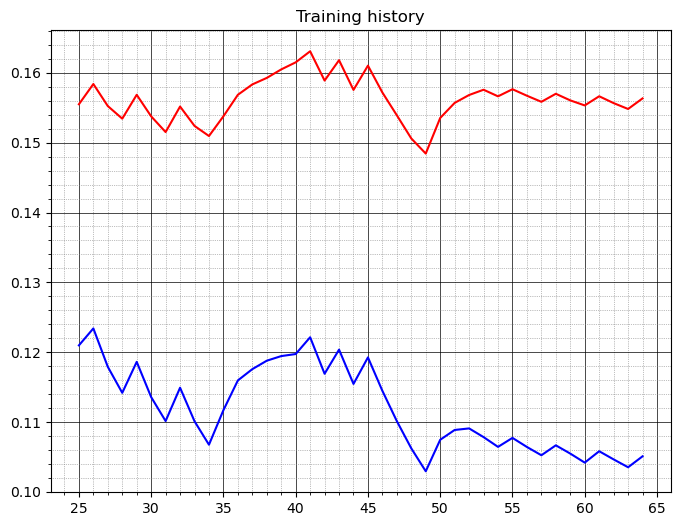

In [97]:
model.plot_history(start=25)

# Inference

In [98]:
import pandas as pd

In [99]:
test_ds = MTDatasetTransformer(pad, src_test, train=False, device=device)
test_dataloader = DataLoader(test_ds, batch_size=hyperparams['batch_size'], shuffle=False)

In [100]:
best_model = Transformer(
    encoder=TransformerEncoder(**hyperparams['model_params'], device=device),
    decoder=TransformerDecoder(**hyperparams['model_params'], device=device),
    positional_encoder=PositionalEncoder(
        d_model=hyperparams['model_params']['d_model'],
        dropout=hyperparams['model_params']['dropout'], 
        max_len=100, 
        device=device
    ), 
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size, 
    pad=pad, 
    device=device,
    d_model=hyperparams['model_params']['d_model'],
    dropout=hyperparams['model_params']['dropout']
)
best_model.load_state_dict(torch.load(best_model_state_path))

<All keys matched successfully>

In [101]:
test_translation = best_model.predict(test_dataloader, max_pred_len=100)

In [102]:
def decode(sequence, pad, vocab):
    '''Index to token conversion'''
    if pad in sequence:
        sequence = sequence[: sequence.index(pad)]
    return ' '.join([vocab.at[index, 'token'] for index in sequence])

In [103]:
tgt_vocab = pd.read_csv('rus_vocab.csv', index_col='idx')

In [104]:
df = pd.read_csv('df_test.csv')

In [105]:
df['translation'] = [decode(sentence, pad, tgt_vocab) for sentence in test_translation]

In [106]:
df

,en,ru,translation
0,Tell them what I told you.,"Скажите им, что я вам сказала.","скажи им то , что я тебе сказал ."
1,"This year, I don't want to celebrate my birthday.",В этом году я не хочу праздновать свой день ро...,в этом году я не хочу отмечать день рождения .
2,Tom couldn't remember where he'd parked his car.,"Том не смог вспомнить, где припарковал машину.","том не мог вспомнить , где припарковал машину ."
3,Tom wasn't the first person to tell me that.,"Том был не первым, кто мне это сказал.","том не тот человек , который мне это было в пе..."
4,The teacher told me to stand up.,Учительница сказала мне встать.,учитель сказал мне встать .
...,...,...,...
95,I have to go meet Tom.,Я должен пойти встретиться с Томом.,мне надо пойти встретить тома .
96,Tom got very good at it.,Том очень в этом поднаторел.,том в этом очень поднаторел .
97,When do you use it?,Когда вы ей пользуетесь?,когда ты ей пользуешься ?
98,It's big.,Она большая.,оно большое .


In [107]:
df.to_excel('result.xlsx', index=False)